# AR & MA Grid — Test (no saving) — 2025-10-23 08:03
Denne notatboken kjører **enkle MA(q)** og **enkle AR(p)** modeller (separate, ikke ARMA/ARIMA),
viser **grafer** for beste modeller og printer **tabeller** med MSE/MAE/MAPE/AIC/Ljung–Box p.
Ingen filer lagres – dette er kun for manuell inspeksjon i testfasen.


In [1]:
# --- Imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller


In [2]:
# --- Helper functions
def residual_diagnostics(resid, lags=24):
    r = pd.Series(resid).dropna()
    lb = acorr_ljungbox(r, lags=[lags], return_df=True)
    return {
        "eps_mean": float(r.mean()),
        "eps_std": float(r.std(ddof=1)),
        f"LjungBox_p(lag{lags})": float(lb["lb_pvalue"].iloc[-1]),
    }

def mae(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return float(np.mean(np.abs(y - yhat)))

def mape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = np.where(y == 0, np.nan, y)
    return float(np.nanmean(np.abs((y - yhat) / denom)) * 100.0)

def adf_p(x):
    x = pd.Series(x).dropna()
    return adfuller(x, autolag="AIC")[1]


In [3]:
# --- Load data (expects train_data.csv / test_data.csv with 'date' and 'volume_all')
train = pd.read_csv("train_data.csv", parse_dates=["date"]).set_index("date").sort_index()
test  = pd.read_csv("test_data.csv",  parse_dates=["date"]).set_index("date").sort_index()

print(f"Train: {train.index.min().date()} → {train.index.max().date()}  rows={len(train)}")
print(f"Test:  {test.index.min().date()}  → {test.index.max().date()}   rows={len(test)}")

# Work on log-volume
train['log_volume'] = np.log(train['volume_all'])
test['log_volume']  = np.log(test['volume_all'])

V_tr = train['log_volume']
V_te = test['log_volume']
y_te_level = np.exp(V_te)

print('ADF p (train log_volume):', adf_p(V_tr))


Train: 2004-01-01 → 2022-12-30  rows=4957
Test:  2023-01-02  → 2025-10-08   rows=723
ADF p (train log_volume): 0.021968939716481256


## MA(q) grid — metrics & forecasts (level)

In [4]:
q_list = [1,2,3,4]
ma_rows, ma_forecasts = [], {}

for q in q_list:
    mdl = sm.tsa.SARIMAX(
        V_tr, order=(0,0,q), trend='c',
        enforce_stationarity=False, enforce_invertibility=True
    ).fit(disp=False)
    fc = mdl.get_forecast(steps=len(V_te))
    sf = fc.summary_frame()
    mu, sigma2 = sf['mean'], sf['mean_se']**2
    pred_level = np.exp(mu + 0.5*sigma2)  # bias-corrected back-transform
    ma_forecasts[q] = pred_level

    mse = float(np.mean((y_te_level - pred_level)**2))
    row = {
        "family":"MA", "order":q, "model":f"MA({q})",
        "AIC": float(mdl.aic),
        "MSE(level)": mse,
        "MAE(level)": mae(y_te_level, pred_level),
        "MAPE(level)": mape(y_te_level, pred_level),
        "LB_p(lag24)": residual_diagnostics(mdl.resid)["LjungBox_p(lag24)"]
    }
    ma_rows.append(row)

ma_results = pd.DataFrame(ma_rows).sort_values("AIC").reset_index(drop=True)
ma_results


/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfugler

,family,order,model,AIC,MSE(level),MAE(level),MAPE(level),LB_p(lag24)
0,MA,4,MA(4),-3154.868973,2.047799e+19,4.118117e+09,38.799103,1.984792e-51
1,MA,3,MA(3),-2881.207731,2.053872e+19,4.125372e+09,38.872492,7.214032e-90
2,MA,2,MA(2),-2088.193560,2.062470e+19,4.135611e+09,38.975795,1.524939e-238
3,MA,1,MA(1),-538.107029,2.049805e+19,4.120643e+09,38.825149,0.000000e+00


## AR(p) grid — metrics & forecasts (level)

In [5]:
p_list = [1,2,3,4]
ar_rows, ar_forecasts = [], {}

for p in p_list:
    mdl = sm.tsa.SARIMAX(
        V_tr, order=(p,0,0), trend='c',
        enforce_stationarity=True, enforce_invertibility=False
    ).fit(disp=False)
    fc = mdl.get_forecast(steps=len(V_te))
    sf = fc.summary_frame()
    mu, sigma2 = sf['mean'], sf['mean_se']**2
    pred_level = np.exp(mu + 0.5*sigma2)
    ar_forecasts[p] = pred_level

    mse = float(np.mean((y_te_level - pred_level)**2))
    row = {
        "family":"AR", "order":p, "model":f"AR({p})",
        "AIC": float(mdl.aic),
        "MSE(level)": mse,
        "MAE(level)": mae(y_te_level, pred_level),
        "MAPE(level)": mape(y_te_level, pred_level),
        "LB_p(lag24)": residual_diagnostics(mdl.resid)["LjungBox_p(lag24)"]
    }
    ar_rows.append(row)

ar_results = pd.DataFrame(ar_rows).sort_values("AIC").reset_index(drop=True)
ar_results


/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfugler

,family,order,model,AIC,MSE(level),MAE(level),MAPE(level),LB_p(lag24)
0,AR,4,AR(4),-4693.777723,1.974355e+19,4.022051e+09,37.805504,1.956590e-26
1,AR,3,AR(3),-4578.752836,1.976754e+19,4.026764e+09,37.858716,2.004117e-44
2,AR,2,AR(2),-4496.885937,1.979348e+19,4.031075e+09,37.905637,5.612680e-57
3,AR,1,AR(1),-4253.327692,1.980298e+19,4.033767e+09,37.937275,5.475849e-85


## Summary table

In [6]:
summary = pd.concat([ma_results, ar_results], ignore_index=True).sort_values(["family","AIC"]).reset_index(drop=True)
summary


,family,order,model,AIC,MSE(level),MAE(level),MAPE(level),LB_p(lag24)
0,AR,4,AR(4),-4693.777723,1.974355e+19,4.022051e+09,37.805504,1.956590e-26
1,AR,3,AR(3),-4578.752836,1.976754e+19,4.026764e+09,37.858716,2.004117e-44
2,AR,2,AR(2),-4496.885937,1.979348e+19,4.031075e+09,37.905637,5.612680e-57
3,AR,1,AR(1),-4253.327692,1.980298e+19,4.033767e+09,37.937275,5.475849e-85
4,MA,4,MA(4),-3154.868973,2.047799e+19,4.118117e+09,38.799103,1.984792e-51
5,MA,3,MA(3),-2881.207731,2.053872e+19,4.125372e+09,38.872492,7.214032e-90
6,MA,2,MA(2),-2088.193560,2.062470e+19,4.135611e+09,38.975795,1.524939e-238
7,MA,1,MA(1),-538.107029,2.049805e+19,4.120643e+09,38.825149,0.000000e+00


## Plot: best MA vs best AR (level)

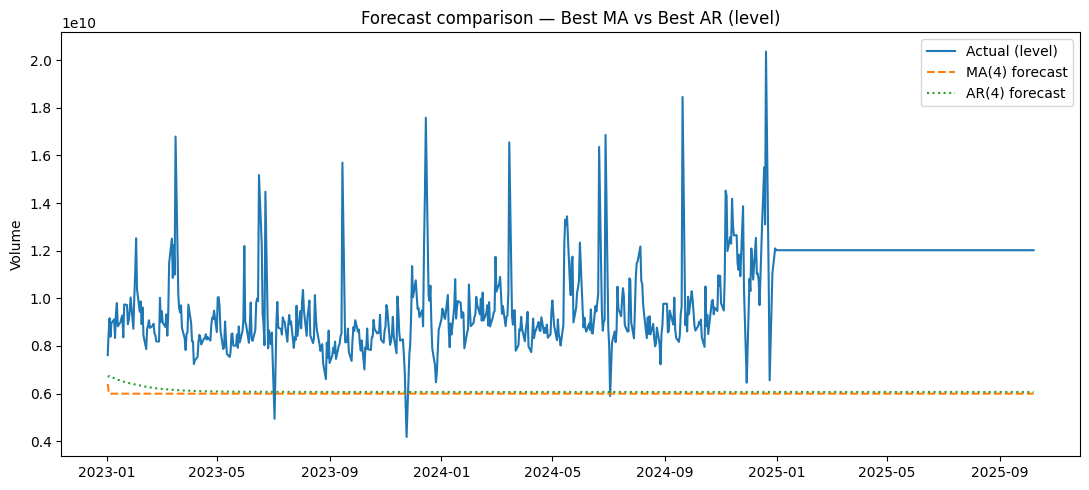

In [7]:
best_ma_q = int(ma_results.loc[ma_results['AIC'].idxmin(), 'order'])
best_ar_p = int(ar_results.loc[ar_results['AIC'].idxmin(), 'order'])

plt.figure(figsize=(11,5))
plt.plot(V_te.index, y_te_level.values, label="Actual (level)")
plt.plot(V_te.index, ma_forecasts[best_ma_q].values, label=f"MA({best_ma_q}) forecast", linestyle="--")
plt.plot(V_te.index, ar_forecasts[best_ar_p].values, label=f"AR({best_ar_p}) forecast", linestyle=":")
plt.title("Forecast comparison — Best MA vs Best AR (level)")
plt.ylabel("Volume"); plt.legend(); plt.tight_layout(); plt.show()


### (Optional) Plot all forecasts

In [ ]:
# Fjern kommentartegn for å vise alle
# plt.figure(figsize=(12,5))
# plt.plot(V_te.index, y_te_level.values, color="black", alpha=0.6, label="Actual (level)")
# for q in q_list:
#     plt.plot(V_te.index, ma_forecasts[q].values, linestyle="--", alpha=0.7, label=f"MA({q})")
# for p in p_list:
#     plt.plot(V_te.index, ar_forecasts[p].values, linestyle=":", alpha=0.7, label=f"AR({p})")
# plt.title("All forecasts (level)")
# plt.ylabel("Volume"); plt.legend(ncol=2); plt.tight_layout(); plt.show()
